# L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5395.3115234375
iteration 0 loss 1808.81201171875


iteration 5000 loss 1.2173937559127808


iteration 10000 loss 0.3724086582660675


iteration 15000 loss 0.49854978919029236


iteration 20000 loss 0.1407570242881775


iteration 25000 loss 74.20800018310547


iteration 30000 loss 0.05673116818070412


iteration 35000 loss 0.046311404556035995


iteration 40000 loss 0.03617328032851219


iteration 45000 loss 0.32026970386505127


iteration 50000 loss 0.01865888200700283


iteration 55000 loss 0.020833084359765053


iteration 60000 loss 0.016742393374443054


iteration 65000 loss 0.010792825371026993


iteration 70000 loss 0.010177843272686005


iteration 75000 loss 0.00852085929363966


iteration 80000 loss 0.007829181849956512


iteration 85000 loss 0.006970891263335943


iteration 90000 loss 0.005568470805883408


iteration 95000 loss 1.0959769487380981


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.004526591394096613


iteration 105000 loss 0.0021958553697913885


iteration 110000 loss 0.0010874312138184905


iteration 115000 loss 0.000643040519207716


iteration 120000 loss 0.0007929041748866439


iteration 125000 loss 0.00030858535319566727


iteration 130000 loss 0.00016954549937509


iteration 135000 loss 0.00011231988173676655


iteration 140000 loss 8.077744132606313e-05


iteration 145000 loss 0.013879664242267609


iteration 150000 loss 0.0001178301390609704


iteration 155000 loss 0.004173606168478727


iteration 160000 loss 0.0006614813464693725


iteration 165000 loss 0.0011128446785733104


iteration 170000 loss 0.0027221895288676023


iteration 175000 loss 0.0035884794779121876


iteration 180000 loss 0.0036302481312304735


iteration 185000 loss 4.734543836093508e-05


iteration 190000 loss 0.00011914434435311705


iteration 195000 loss 0.0030227038078010082


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00016333165694959462


iteration 205000 loss 0.00015763127885293216


iteration 210000 loss 1.2360428627289366e-06


iteration 215000 loss 8.674917353346245e-07


iteration 220000 loss 8.300577860609337e-07


iteration 225000 loss 3.928791727503267e-07


iteration 230000 loss 2.705201040953398e-07


iteration 235000 loss 1.869067318693851e-07


iteration 240000 loss 1.32317211409827e-07


iteration 245000 loss 6.349301315822231e-07


iteration 250000 loss 7.273595059587024e-08


iteration 255000 loss 5.679823189552735e-08


iteration 260000 loss 4.4221518891163214e-08


iteration 265000 loss 3.526038838685963e-08


iteration 270000 loss 9.593961891596336e-08


iteration 275000 loss 2.5030736594544578e-08


iteration 280000 loss 1.7944239516509697e-05


iteration 285000 loss 1.818724193469734e-08


iteration 290000 loss 1.7265060492377415e-08


iteration 295000 loss 1.5100560801784013e-08


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.2895326584327904e-08


iteration 305000 loss 1.0694100716079902e-08


iteration 310000 loss 7.768163889920743e-09


iteration 315000 loss 6.590455292609931e-09


iteration 320000 loss 6.135407293328399e-09


iteration 325000 loss 6.245610695287951e-09


iteration 330000 loss 8.70153549215047e-09


iteration 335000 loss 4.559156607797377e-09


iteration 340000 loss 4.01020017193332e-09


iteration 345000 loss 3.754863531213459e-09


iteration 350000 loss 3.972657314221806e-09


iteration 355000 loss 3.1960396551511394e-09


iteration 360000 loss 2.9203426343826777e-09


iteration 365000 loss 2.9191589145938224e-09


iteration 370000 loss 3.0306246401323733e-09


iteration 375000 loss 5.080715403948943e-09


iteration 380000 loss 2.527884790382018e-09


iteration 385000 loss 2.2393420451294332e-09


iteration 390000 loss 2.077695127056245e-09


iteration 395000 loss 1.9472128354180995e-09


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.6808509029075935e-09


iteration 405000 loss 1.565646390311315e-09


iteration 410000 loss 1.464776522297484e-09


iteration 415000 loss 1.4204797338379649e-09


iteration 420000 loss 1.3585602642862682e-09


iteration 425000 loss 1.3184194846971309e-09


iteration 430000 loss 1.305238694904176e-09


iteration 435000 loss 1.5715424517281917e-09


iteration 440000 loss 1.2093863688278361e-09


iteration 445000 loss 1.1864093041324963e-09


iteration 450000 loss 1.1579075476220169e-09


iteration 455000 loss 1.1117160525486725e-09


iteration 460000 loss 1.0936378469494912e-09


iteration 465000 loss 1.078816036503838e-09


iteration 470000 loss 1.0280822859698446e-09


iteration 475000 loss 1.0873867362093392e-09


iteration 480000 loss 1.099667135129323e-09


iteration 485000 loss 9.608880358058514e-10


iteration 490000 loss 9.378116061498076e-10


iteration 495000 loss 8.949053165174803e-10


L2 loss -- Plot

loss -100.47824096679688


loss -330.2360534667969


loss -446.2923278808594


loss -539.8997192382812


loss -626.4334716796875


loss -708.0545654296875


loss -784.7852783203125


loss -856.150634765625


loss -921.4873046875


loss -980.0458374023438


loss -1031.276611328125


loss -1075.124267578125


loss -1112.0369873046875


loss -1142.7254638671875


loss -1167.875244140625


loss -1188.0626220703125


loss -1203.8240966796875


loss -1215.702880859375


loss -1224.266845703125


loss -1230.112060546875


loss -1233.8385009765625


loss -1236.020263671875


loss -1237.16796875


loss -1237.6954345703125


loss -1237.899658203125


loss -1237.9630126953125


loss -1237.977783203125


loss -1237.9801025390625


loss -1237.980224609375


loss -1237.9803466796875


loss -1237.9803466796875


loss -1237.9803466796875


loss -1237.98046875


loss -1237.98046875


loss -1237.9803466796875


loss -1237.9803466796875


loss -1237.9803466796875


loss -1237.98046875


loss -1237.98046875


loss -1237.98046875


final mse:  4.152059251971707e-10
max, min: 9.519948 -9.945817
loss -100.47824096679688


loss -328.04766845703125


loss -445.38604736328125


loss -540.0300903320312


loss -626.930908203125


loss -709.2177734375


loss -787.0884399414062


loss -859.9549560546875


loss -927.0806274414062


loss -987.8582763671875


loss -1042.0859375


loss -1089.83740234375


loss -1131.210205078125


loss -1166.310791015625


loss -1195.28173828125


loss -1218.402099609375


loss -1236.171142578125


loss -1249.29736328125


loss -1258.607666015625


loss -1264.92626953125


loss -1268.9903564453125


loss -1271.42236328125


loss -1272.73828125


loss -1273.3583984375


loss -1273.6009521484375


loss -1273.675048828125


loss -1273.6912841796875


loss -1273.693603515625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


loss -1273.69384765625


final mse:  2.9141075663652316e-10
max, min: 9.944739 -9.718446


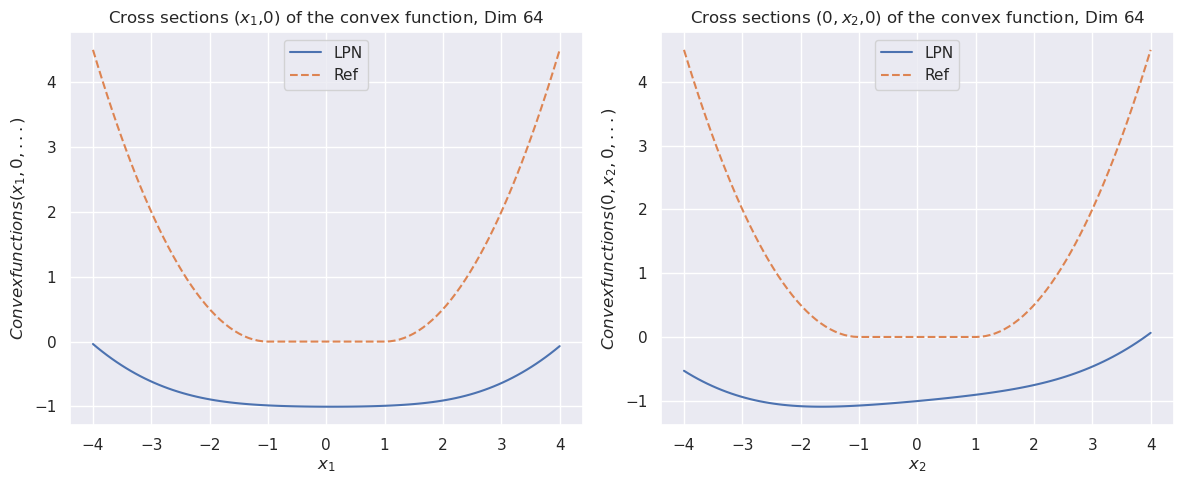

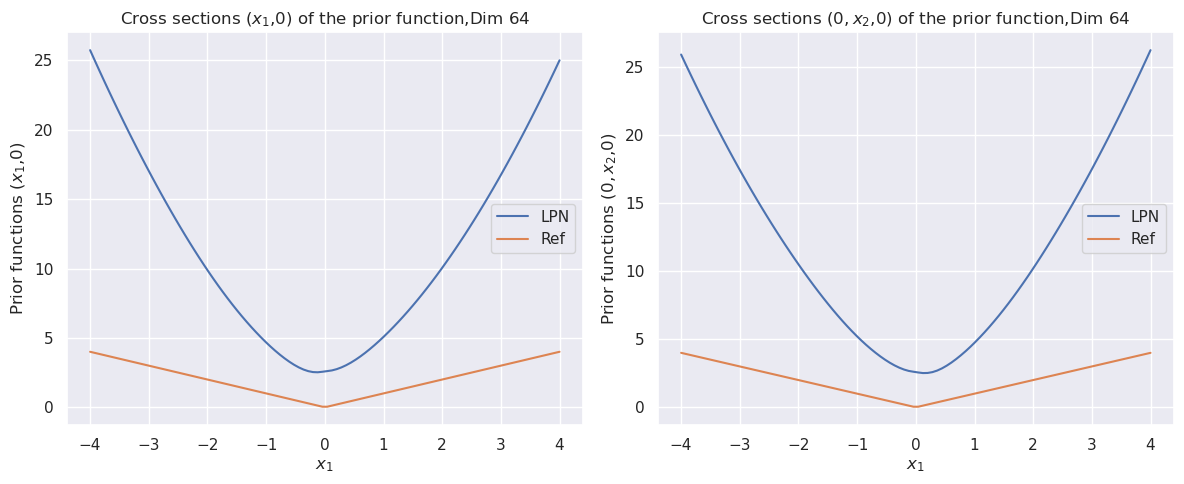

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 10988.017578125
iteration 0 loss 6461.68115234375


iteration 5000 loss 1.1110203266143799


iteration 10000 loss 0.2782612442970276


iteration 15000 loss 3.276111602783203


iteration 20000 loss 0.12745842337608337


iteration 25000 loss 0.08991023898124695


iteration 30000 loss 0.07058840245008469


iteration 35000 loss 0.05813608318567276


iteration 40000 loss 0.052952464669942856


iteration 45000 loss 0.0462048202753067


iteration 50000 loss 0.03813797980546951


iteration 55000 loss 0.03984714671969414


iteration 60000 loss 0.031661584973335266


iteration 65000 loss 0.029874859377741814


iteration 70000 loss 0.026488084346055984


iteration 75000 loss 0.02866397611796856


iteration 80000 loss 0.0203187745064497


iteration 85000 loss 0.01922786608338356


iteration 90000 loss 0.024789853021502495


iteration 95000 loss 0.017029084265232086


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.017800182104110718


iteration 105000 loss 0.012160719372332096


iteration 110000 loss 0.009377687238156796


iteration 115000 loss 0.007762879133224487


iteration 120000 loss 0.00649998290464282


iteration 125000 loss 0.005527110770344734


iteration 130000 loss 0.00474056089296937


iteration 135000 loss 0.004063875414431095


iteration 140000 loss 0.0034810167271643877


iteration 145000 loss 0.003014008281752467


iteration 150000 loss 0.0026180148124694824


iteration 155000 loss 0.002277856459841132


iteration 160000 loss 0.0020054541528224945


iteration 165000 loss 0.001792142284102738


iteration 170000 loss 0.0015669387066736817


iteration 175000 loss 0.0013954667374491692


iteration 180000 loss 0.0012436909601092339


iteration 185000 loss 0.0011169050121679902


iteration 190000 loss 0.0010234365472570062


iteration 195000 loss 0.0009027408086694777


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.000816278625279665


iteration 205000 loss 0.0007784717599861324


iteration 210000 loss 0.000700335600413382


iteration 215000 loss 0.0006290117162279785


iteration 220000 loss 0.0005678772577084601


iteration 225000 loss 0.0005140333087183535


iteration 230000 loss 0.00046358813415281475


iteration 235000 loss 0.00042072462383657694


iteration 240000 loss 0.00038046177360229194


iteration 245000 loss 0.00034933933056890965


iteration 250000 loss 0.0003179635386914015


iteration 255000 loss 0.00028894408023916185


iteration 260000 loss 0.00026284443447366357


iteration 265000 loss 0.0002419767261017114


iteration 270000 loss 0.00022168178111314774


iteration 275000 loss 0.00020230347581673414


iteration 280000 loss 0.0001844713115133345


iteration 285000 loss 0.0001702537265373394


iteration 290000 loss 0.00015588593669235706


iteration 295000 loss 0.00014237660798244178


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00013092828157823533


iteration 305000 loss 0.00012656362378038466


iteration 310000 loss 0.00011532954522408545


iteration 315000 loss 0.00010557271889410913


iteration 320000 loss 9.665432298788801e-05


iteration 325000 loss 8.796080510364845e-05


iteration 330000 loss 8.019643428269774e-05


iteration 335000 loss 7.391650433419272e-05


iteration 340000 loss 6.786114681744948e-05


iteration 345000 loss 6.236057379283011e-05


iteration 350000 loss 5.719466571463272e-05


iteration 355000 loss 5.2395640523172915e-05


iteration 360000 loss 4.801014074473642e-05


iteration 365000 loss 4.446507591637783e-05


iteration 370000 loss 4.117727803532034e-05


iteration 375000 loss 3.7826521293027326e-05


iteration 380000 loss 3.5185898013878614e-05


iteration 385000 loss 3.244686740799807e-05


iteration 390000 loss 2.9830558560206555e-05


iteration 395000 loss 2.736546957748942e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 2.5228571757907048e-05


iteration 405000 loss 2.389839937677607e-05


iteration 410000 loss 2.1358260710258037e-05


iteration 415000 loss 1.9042638086830266e-05


iteration 420000 loss 1.7079597455449402e-05


iteration 425000 loss 1.5224062735796906e-05


iteration 430000 loss 1.3526095244742464e-05


iteration 435000 loss 1.202368821395794e-05


iteration 440000 loss 1.0714401469158474e-05


iteration 445000 loss 9.50115190789802e-06


iteration 450000 loss 8.424579391430598e-06


iteration 455000 loss 7.5031530286651105e-06


iteration 460000 loss 6.749014573870227e-06


iteration 465000 loss 6.0845650295959786e-06


iteration 470000 loss 5.536494427360594e-06


iteration 475000 loss 5.058658189227572e-06


iteration 480000 loss 4.625157998816576e-06


iteration 485000 loss 4.262741185812047e-06


iteration 490000 loss 3.965400992456125e-06


iteration 495000 loss 3.6679214190371567e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


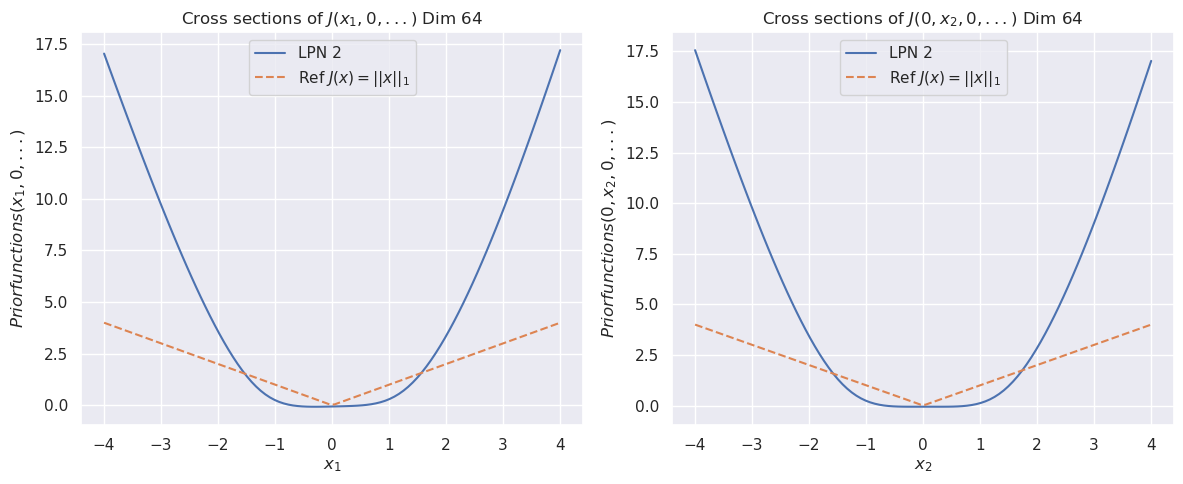

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)